<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/Seq2seq_Bayesian_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/aybchan/uber-time-series.git

Cloning into 'uber-time-series'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 279 (delta 9), reused 20 (delta 5), pack-reused 245
Receiving objects: 100% (279/279), 18.78 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [2]:
%cd uber-time-series/

/content/uber-time-series


In [7]:
# allows for import from `src` directory
import sys 
sys.path.append('../')

In [10]:
import os
import subprocess
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

DATASET = 'Metro_Interstate_Traffic_Volume.csv'

class TrafficDataset(Dataset):
    """
    PyTorch Dataset class for Metro Traffic dataset
    """
    def __init__(self, samples, n_input_steps, key='train', pretraining=True):
        # calculate normalisation parameters for columns
        # `temp`, `rain_1h`, `clouds_all` and `traffic_volume`
        # from training data
        self.X_train = samples['train'][:,:n_input_steps,:].copy()

        cols_to_normalise = [0,1,3,4]
        self.train_mu, self.train_sigma  = [], []
        for c in cols_to_normalise:
            self.train_mu.append(np.mean(np.hstack([self.X_train[:,0,c],
                                               self.X_train[-1,1:,c]])))
            self.train_sigma.append(np.std(np.hstack([self.X_train[:,0,c],
                                                 self.X_train[-1,1:,c]])))

        # normalise dataset
        self.X = samples[key][:,:n_input_steps,:].copy()
        self.y = samples[key][:,n_input_steps:,:].copy()
        for c,col in enumerate(cols_to_normalise):
            self.X[:,:,col] = (self.X[:,:,col] - self.train_mu[c])/(self.train_sigma[c])
            self.y[:,:,col] = (self.y[:,:,col] - self.train_mu[c])/(self.train_sigma[c])
        
        # added from notebook 6 to provide external features for prediction network
        self.pretraining = pretraining
        self.prediction_cols = [40, 41, 42, 43, 44, 45, 46, 47, 48, 
                            49, 50, 51, 52, 53, 54, 55, 56, 57]

    def __len__(self):
        return len(self.y)


    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx,:,:]).float()
        if self.pretraining:
            y = torch.Tensor(self.y[idx,:,4] - self.X[idx,0,4]).float()
        else:
            y = self.y[idx,:,:].copy()
            y[:,4] -= self.X[idx,0,4]
            y = torch.Tensor(y[:,[4] + self.prediction_cols]).float()
            
        return x, y


def get_datasets(samples, n_input_steps, pretraining=True):
    datasets = {}
    for key, sample in samples.items():
        datasets[key] = TrafficDataset(samples, n_input_steps, key, pretraining)

    return datasets


def get_dataloaders(datasets, train_batch_size):
    dataloaders = {}
    for key, dataset in datasets.items():
        if key == 'train':
            dataloaders[key] = DataLoader(dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True)
        else:
            dataloaders[key] = DataLoader(dataset,
                                          batch_size=len(dataset),
                                          shuffle=False)

    return dataloaders


def pipeline(n_input_steps: int, n_pred_steps: int):
    df = pd.read_csv(r'/content/uber-time-series/Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip', header=0,  quotechar='"', error_bad_lines=False)

    df = time_preprocessing(df) # 1.1.3, 1.2
    df = deal_with_anomalies(df) #1.3, 1.3.1, 1.3.2
    df = create_weather_features(df) # 1.4.1
    df = create_holiday_features(df) # 1.4.2
    df = create_time_features(df) # 1.4.3
    df = drop_string_features(df)

    split_dfs = split_dataframe(df) # 1.5.1
    samples = create_samples(split_dfs, n_input_steps, n_pred_steps) # 1.5.2

    return df, split_dfs, samples


def full_pipeline(params):
    # run the data preprocessing pipeline to create dataset
    df, split_dfs, samples = pipeline(params['data']['n_input_steps'], params['models']['prediction']['n_output_steps'], '../data')

    # we modify the get_datasets function to return external features in the y labels
    datasets = get_datasets(samples, params['data']['n_input_steps'], pretraining=False)

    dataloaders = get_dataloaders(datasets, train_batch_size=256)
    # nb. batch_size refers to training batch_size which we have previously done hyperparameter
    # on the pretraining and prediction networks for. it is irrelevant for this notebook because
    # we will not be training anything
    return df, dataloaders

def download(DATA_PATH: str):
    """
    https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
    """

    if not os.path.exists(f'{DATA_PATH}/{DATASET}'):
        # create data dir
        Path(DATA_PATH).mkdir(parents=True, exist_ok=True)

        # download and extract data
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
        subprocess.run(['curl', '-o', f'{DATA_PATH}/{DATASET}.gz', url])
        subprocess.run(['gzip', '-d', f'{DATA_PATH}/{DATASET}.gz'])
        print('Downloaded data\n')

    else:
        print('Data already downloaded\n')


def time_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # 1.1.2
    time_col = 'date_time'
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col)

    # 1.1.3
    df = df.iloc[df[time_col].drop_duplicates(keep='last').index]

    # 1.2
    # get the first and last timestamps
    start, end = df.date_time.iloc[[0,-1]].values

    # get a list of hourly timestamps in this range
    full_range = pd.date_range(start, end, freq='H')
    df = pd.DataFrame(full_range, columns=[time_col]).merge(df, on=time_col, how='outer')
    df = df.set_index(time_col)

    return df


def deal_with_anomalies(df: pd.DataFrame) -> pd.DataFrame:
    # rain_1h anomaly
    second_largest_rain_1h = df['rain_1h'].sort_values(ascending=False)[1]
    rain_1h_mask = df['rain_1h'] > 5000
    largest_rain_1h_idx = np.where(rain_1h_mask)[0][0]
    df.at[df.iloc[largest_rain_1h_idx].name, 'rain_1h'] = second_largest_rain_1h

    # temp anomaly
    temp_mask = df['temp'] < 100
    smallest_temp_idx = np.where(temp_mask)[0][0]
    # get interpolated value
    temp_imputate_value = df['temp'].iloc[[smallest_temp_idx-1,smallest_temp_idx+5]].mean()

    # fill in anomalous values
    for i in range(smallest_temp_idx,smallest_temp_idx+4):
        idx = df.iloc[i].name
        df.at[idx, 'temp'] = temp_imputate_value

    return df


def create_weather_features(df: pd.DataFrame) -> pd.DataFrame:
    dummies = pd.get_dummies(df['weather_description'], prefix='weather')
    df[dummies.columns] = dummies

    return df


def create_holiday_features(df: pd.DataFrame) -> pd.DataFrame:
    dummies = pd.get_dummies(df['holiday'], prefix='holiday')
    df[dummies.columns] = dummies

    return df


def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    hour_sin = np.sin(2*np.pi*(df.index.hour.values/24))
    hour_cos = np.cos(2*np.pi*(df.index.hour.values/24))
    df['hour_sin'] = hour_sin
    df['hour_cos'] = hour_cos

    weekday_sin = np.sin(2*np.pi*(df.index.isocalendar().day/7))
    weekday_cos = np.cos(2*np.pi*(df.index.isocalendar().day/7))
    df['weekday_sin'] = weekday_sin
    df['weekday_cos'] = weekday_cos

    yearweek_sin = np.sin(2*np.pi*(df.index.isocalendar().week/52))
    yearweek_cos = np.cos(2*np.pi*(df.index.isocalendar().week/52))
    df['yearweek_sin'] = yearweek_sin
    df['yearweek_cos'] = yearweek_cos

    return df


def drop_string_features(df: pd.DataFrame) -> pd.DataFrame:
    str_columns = ['weather_main','weather_description','holiday']
    df = df.drop(str_columns,axis=1)

    return df


def split_dataframe(df: pd.DataFrame) -> dict:
    test_start_time  = df.index[-1] - np.timedelta64(30*6,  'D')
    valid_start_time = df.index[-1] - np.timedelta64(30*12, 'D')
    ranges = {
        'train': (df.index[0], valid_start_time),
        'valid': (valid_start_time, test_start_time),
        'test':  (test_start_time, df.index[-1])
    }

    datasets = {}
    time_to_index = lambda time: np.where(df.index == time)[0][0]

    datasets['train'] = df.iloc[:time_to_index(valid_start_time)]
    datasets['valid'] = df.iloc[time_to_index(valid_start_time):
                                time_to_index(test_start_time)]
    datasets['test']  = df.iloc[time_to_index(test_start_time):]

    for key,dataset in datasets.items():
        print(dataset.shape[0], key, 'rows from', ranges[key][0], 'to', ranges[key][1])

    print()

    return datasets


def create_samples(datasets: dict, n_input_steps: int, n_pred_steps: int) -> dict:
    data = {}
    for key,dataset in datasets.items():
        dataset = datasets[key]
        n_cols = dataset.shape[1]
        dataset = dataset.values.astype(np.float64)

        idxs = np.arange(dataset.shape[0])
        n_timesteps = n_input_steps + n_pred_steps
        n_samples = dataset.shape[0] - n_timesteps + 1
        stride = idxs.strides[0]
        sample_idxs = np.lib.stride_tricks.as_strided(idxs, shape=(n_samples, n_timesteps), strides=(stride, stride))

        samples = dataset[sample_idxs]
        useable = np.all(~np.isnan(samples.reshape(-1, n_timesteps*n_cols)),axis=-1)
        data[key] = samples[useable]

        print(data[key].shape[0], f'samples of {n_input_steps} input steps and {n_pred_steps} output steps in', key)

    print()

    return data

In [9]:
! wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

--2022-06-29 08:09:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K   478KB/s    in 0.8s    

2022-06-29 08:09:15 (478 KB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



In [11]:
n_input_steps  = 48
n_output_steps = 12

# run the preprocessing pipeline
df, split_dfs, samples = pipeline(n_input_steps, n_output_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """


43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00

16625 samples of 48 input steps and 12 output steps in train
3534 samples of 48 input steps and 12 output steps in valid
4020 samples of 48 input steps and 12 output steps in test



In [12]:
batch_size = 128
datasets = data.get_datasets(samples, n_input_steps)
dataloaders = data.get_dataloaders(datasets, batch_size)

In [13]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.model = nn.ModuleDict({
            'lstm1': nn.LSTM(in_features, 32),
            'lstm2': nn.LSTM(32, 8),
            'lstm3': nn.LSTM(8, out_features)
        })
    
    def forward(self, x):
        out, _ = self.model['lstm1'](x)
        out, _ = self.model['lstm2'](out)
        out, _ = self.model['lstm3'](out)
        
        return out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.ModuleDict({
            'lstm1': nn.LSTM(1, 1),
            'lstm2': nn.LSTM(1, 1),
            'lstm3': nn.LSTM(1, 1)
        })
    
    def forward(self, x):
        out, _ = self.model['lstm1'](x)
        out, _ = self.model['lstm2'](out)
        out, _ = self.model['lstm3'](out)

        return out


class EncoderDecoder(nn.Module):
    def __init__(self, in_features, f):
        super(EncoderDecoder, self).__init__()
        self.f = f
        self.in_features = in_features
        self.traffic_col = 4
        
        self.model = nn.ModuleDict({
            'encoder': Encoder(self.in_features, 1),
            'decoder': Decoder(),
            'fc1': nn.Linear(60, 32),
            'fc2': nn.Linear(32, self.f)
        })

    def forward(self, x):
        out = self.model['encoder'](x)
        
        # concatenate the auxiliary time series values 
        # with the output from the encoder (the embedding)
        x_auxiliary = x[:,-self.f:,[self.traffic_col]]
        decoder_input = torch.cat([out, x_auxiliary], dim=1)

        out = self.model['decoder'](decoder_input)
        out = self.model['fc1'](out.view(-1, 60))
        out = self.model['fc2'](out)

        return out

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

num_epochs = 50
learning_rate = 1e-3

model = EncoderDecoder(in_features=datasets['train'].X.shape[-1], 
                       f=n_output_steps).to(device)

losses = []
optimiser = optim.Adam(lr=learning_rate,
                       params=model.parameters())

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i,(x,y) in enumerate(dataloaders['train']):
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        
        optimiser.zero_grad()
        loss = F.mse_loss(out, y)
        loss.backward()
        optimiser.step()
        
        step = (epoch * len(dataloaders['train'].dataset) +
                i * batch_size + len(x))

        losses.append([step, loss.item()])
        pbar.set_description("Epoch={0} | [{1:>5}|{2}]\tloss={3:.4f}"
                             .format(epoch,
                                     i * batch_size + len(x),
                                     len(dataloaders['train'].dataset),
                                     loss.item()))

Epoch=49 | [16625|16625]	loss=0.1125: 100%|██████████| 50/50 [03:26<00:00,  4.12s/it]


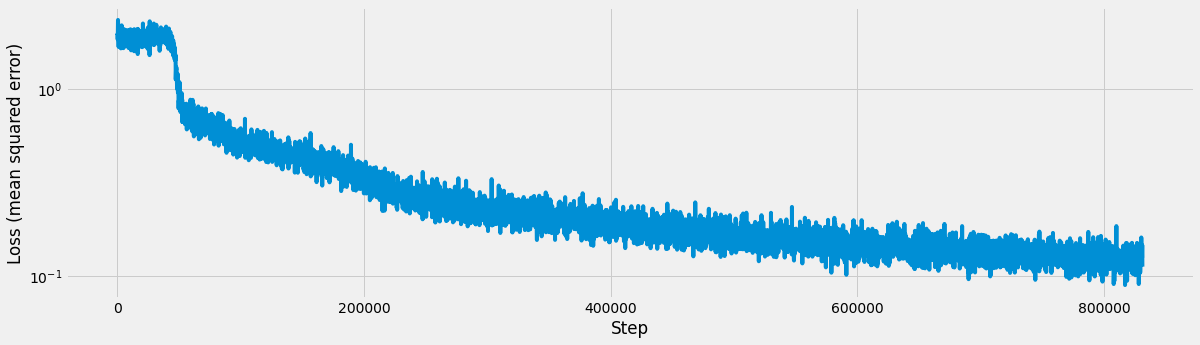

In [18]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

fig, axs = plt.subplots(1,1, figsize=(18,5))
_   = axs.plot(*np.array(losses)[:].T,label='training loss')
_   = axs.set_ylabel('Loss (mean squared error)')
_   = axs.set_xlabel('Step')
_   = axs.set_yscale('log')

In [24]:
for x,y in dataloaders['valid']:
    break
x = x.to(device)
y_pred = model(x)


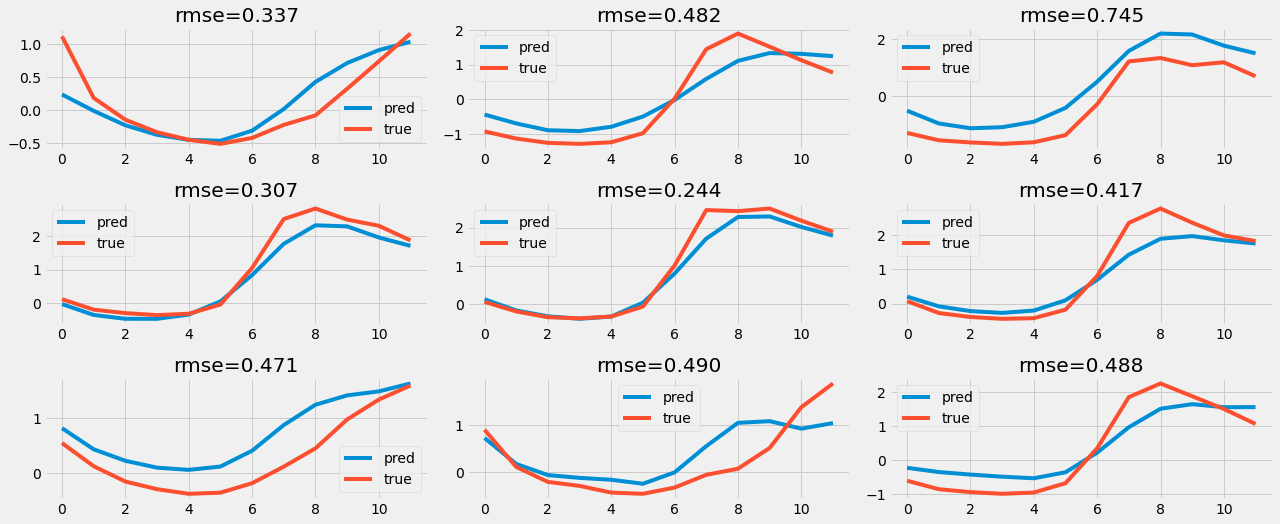

In [27]:
y_pred = y_pred.cpu().detach().numpy()[::24]
y = y[::24]

n_rows, n_cols = 3,3
fig,axs = plt.subplots(n_rows, n_cols,figsize=(6*n_cols, 2.5*n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_rows+c
        axs[r][c].plot(y_pred[i],label='pred')
        axs[r][c].plot(y[i,:].numpy(),label='true')
        axs[r][c].legend()
        rmse = np.sqrt(np.mean((y_pred[i] - y[i,:].numpy())**2))
        axs[r][c].set_title('rmse={0:.3f}'.format(rmse))
plt.tight_layout()

In [ ]:
n_rows, n_cols = 3,3
fig,axs = plt.subplots(n_rows, n_cols,figsize=(6*n_cols, 2.5*n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_rows+c
        axs[r][c].plot(y_pred[i],label='pred')
        axs[r][c].plot(y[i,:].numpy(),label='true')
        axs[r][c].legend()
        rmse = np.sqrt(np.mean((y_pred[i] - y[i,:].numpy())**2))
        axs[r][c].set_title('rmse={0:.3f}'.format(rmse))
plt.tight_layout()